In [1]:
from omegaconf import OmegaConf
from vitssm.models import build_model
from vitssm.data import get_dataset
import torch

config = OmegaConf.load("configs/UPT/upt_3d_t_32_config.yml")
config.dataset.load_in_memory = False
config.model.upt_autoencoder_checkpoint_path = "/home/david/projects/ViTSSM/checkpoints/ViTSSM/UPT/vmdsprites-UPT_VAE_T-32.pth"

model = build_model(config.model)
dataset = get_dataset(config.dataset)

app_checkpoint_path = "/home/david/projects/ViTSSM/checkpoints/ViTSSM/UPT/vmdsprites-UPT_3D_T-32.pth"
ckpt = torch.load(app_checkpoint_path)
app_ckpt = {key[13:]: val for key, val in ckpt["model"].items() if key.startswith("approximator")}

model.approximator.load_state_dict(app_ckpt)

/home/david/projects/ViTSSM/vitssm/models/upt/_next_frame.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(upt_autoencoder_checkpoint_path)
/tmp

<All keys matched successfully>

In [19]:
x = dataset[69][0].unsqueeze(0)

torch.Size([128, 3, 32, 32])


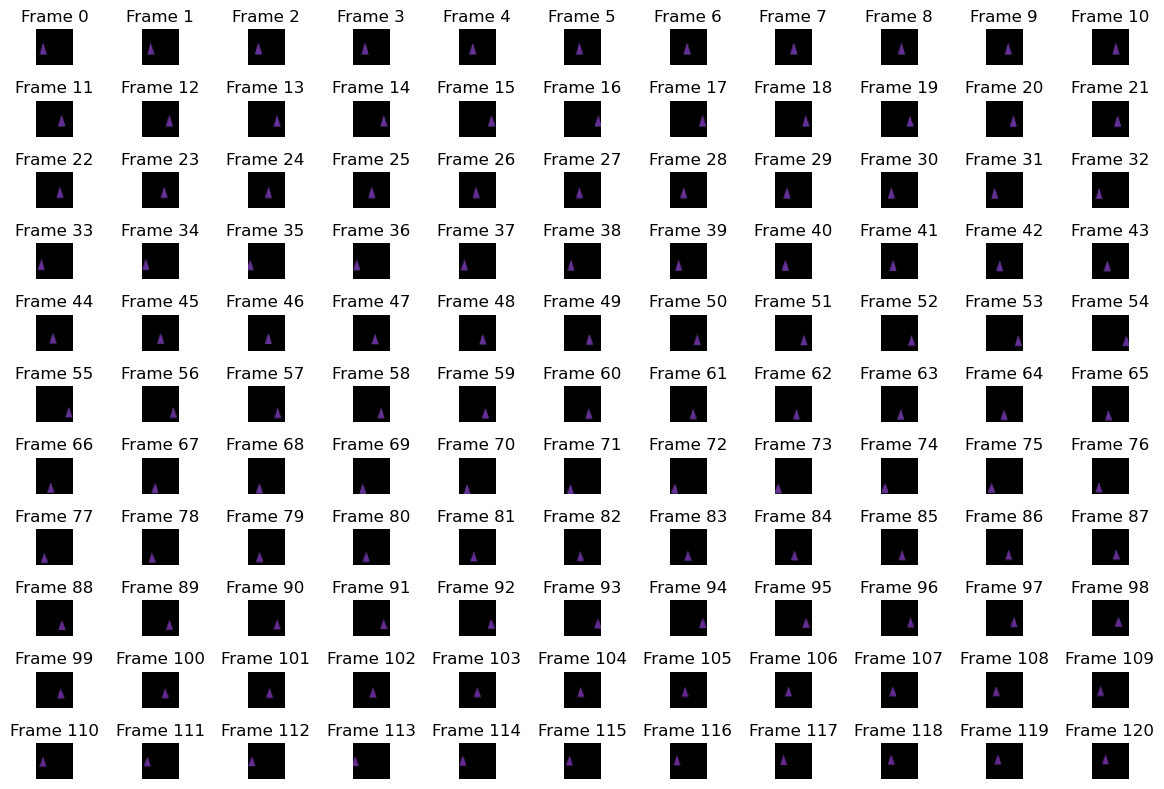

In [20]:
from vitssm.utils.visual import model_output_to_video, display_video_frames_in_grid
from einops import rearrange, repeat
from torchvision.io import write_video
import imageio
import numpy as np

bs, cl, ch, ht, wt = x.shape
spatial_scale = 1
temporal_scale = 1
device = torch.device("cuda")


model.eval()
model.to(device)

x_pred = model.rollout_frames(x.to(device), n_steps=128, temporal_scale=temporal_scale, spatial_scale=spatial_scale).squeeze(0).cpu()

print(x_pred.shape)
display_video_frames_in_grid(x_pred)
imageio.mimsave("x_pred.gif", [np.array(x) for x in rearrange(model_output_to_video(x_pred), "... c h w -> ... h w c")])

In [11]:
imageio.help(".gif")

GIF-PIL - Compuserve GIF via Pillow

    See :mod:`imageio.plugins.pillow_legacy`



In [4]:
import numpy as np

[np.array(x) for x in x_pred]

/tmp/ipykernel_13560/2708407521.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  [np.array(x) for x in x_pred]


[array([[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]],
 
        [[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         ...,
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.]]], dtype=float32),
 array([[[-1., -1., -1., ..., -1., -1., -1.],
         [-1., -1., -1., ..., -1., -1., -1.],
         [-1.,

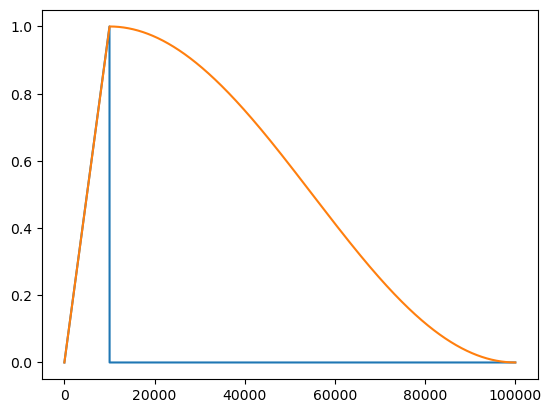

In [2]:
import matplotlib.pyplot as plt
import numpy as np

warmup_steps = 10000
decay_steps = 90000
scheduler_gamma = 0.0


def warm_and_exp_decay_lr(step: int):
    if step < warmup_steps:
        return step / warmup_steps

    return scheduler_gamma ** (step / decay_steps - warmup_steps / decay_steps)

def warm_and_cosine_decay_lr(step: int):
    if step < warmup_steps:
        return step / warmup_steps

    return scheduler_gamma + 0.5 * (1 - scheduler_gamma) * (1 + np.cos((step / decay_steps - warmup_steps / decay_steps) * np.pi))

x = list(range(100000))
y_exp = list(map(warm_and_exp_decay_lr, x))
y_cos = list(map(warm_and_cosine_decay_lr, x))
plt.plot(x, y_exp, label="exp")
plt.plot(x, y_cos, label="cos")

In [ ]:
from vitssm.models.upt._autoencoder import UPTVAE_M
from vitssm.models.upt._approximator import UPTA_M
from vitssm.utils import count_parameters
import torch
from einops import rearrange, repeat

ae = UPTVAE_M(resolution=(4, 32, 32)
app = UPTA_M(context_length=4)

#x = torch.randn(1, 4, 3, 32, 32)
#
#b, f, c, h, w = x.shape
#x = rearrange(x, "b f c h w -> (b f) c h w")
#output_pos = rearrange(
#    torch.stack(torch.meshgrid([torch.arange(32), torch.arange(32)], indexing="ij")),
#    "ndim height width -> (height width) ndim",
#).float()
#
#x = ae.encode(x)
#print(x.shape)
#x = rearrange(x, "(b f) t e -> b f t e", b=b, f=f)
#x = app(x)
#print(x.shape)

print("autoencoder: ", count_parameters(ae))
print("approximator: ", count_parameters(app))
print("total: ", count_parameters(ae) + count_parameters(app))

autoencoder:  2038275
approximator:  894720
total:  2932995


In [3]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def compare_downsampling(tensor, target_size):
    """
    Compare different downsampling algorithms visually.

    Args:
        tensor (torch.Tensor): Input image tensor in C, H, W format.
        target_size (tuple): Target size as (height, width).
    """
    # Ensure the tensor is in C, H, W format
    if tensor.ndim != 3:
        raise ValueError("Input tensor must be in C, H, W format.")

    # Normalize tensor for visualization
    tensor = tensor / tensor.max()

    # Convert to PIL image for compatibility with transforms
    to_pil = transforms.ToPILImage()
    pil_image = to_pil(tensor)

    # Define interpolation methods to compare
    interpolation_methods = {
        "Nearest": transforms.InterpolationMode.NEAREST,
        "Bilinear": transforms.InterpolationMode.BILINEAR,
        "Bicubic": transforms.InterpolationMode.BICUBIC,
        "Lanczos": transforms.InterpolationMode.LANCZOS,
    }

    # Create a subplot for each interpolation method plus the original
    fig, axes = plt.subplots(1, len(interpolation_methods) + 1, figsize=(18, 5))

    # Show the original image
    axes[0].imshow(pil_image)
    axes[0].set_title("Original")
    axes[0].axis("off")

    # Show the resized images for each interpolation method
    for ax, (name, mode) in zip(axes[1:], interpolation_methods.items()):
        # Apply resizing
        resize_transform = transforms.Resize(target_size, interpolation=mode)
        resized_image = resize_transform(pil_image)

        # Show the resized image
        ax.imshow(resized_image)
        ax.set_title(name)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

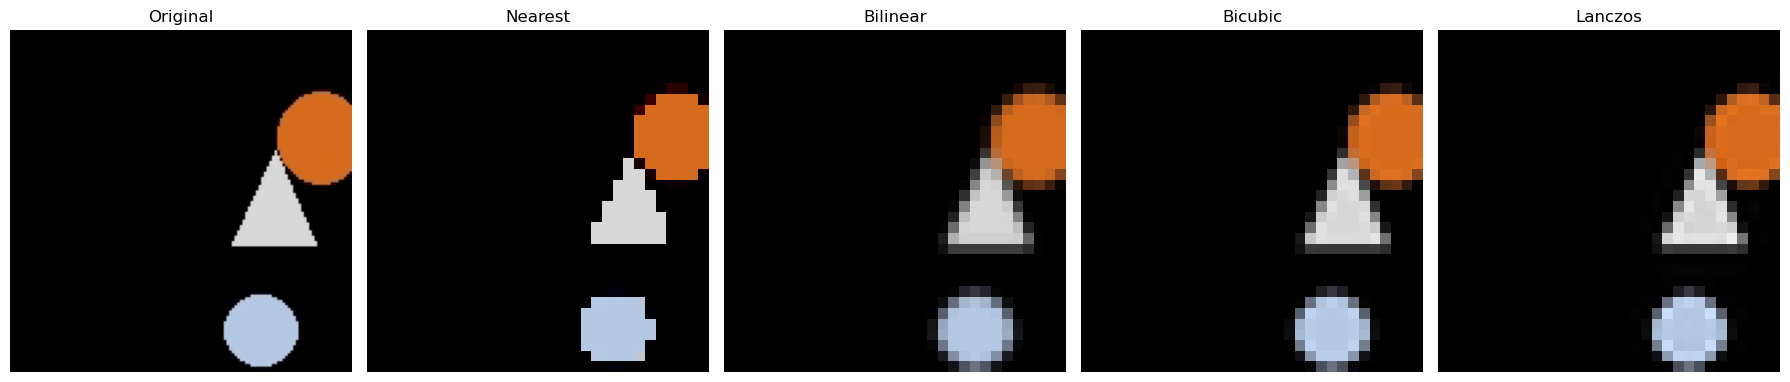

In [4]:
from vitssm.data.datasets import VideoDataset
from vitssm.utils.visual import unnormalize

dataset = VideoDataset("data_store/VMDsprites_128/folds/train_0.csv", image_size=(128, 128))

x = unnormalize(dataset[69][0]) * 255

compare_downsampling(x, target_size=(32, 32))

In [12]:
from vitssm.data.datasets import VariableResolutionAEDatasetWrapper
from einops import rearrange
from vitssm.utils.visual import model_output_to_image, model_output_to_video

dataset = VariableResolutionAEDatasetWrapper(VideoDataset("data_store/VMDsprites_128/folds/train_0.csv", image_size=(128, 128)), 32, False, 4)

x, y = dataset[69]

In [13]:
coords = y["coords"].unsqueeze(0)
values = y["values"].unsqueeze(0)

t, h, w = tuple(len(torch.unique(coords[0, :, i])) for i in range(coords.size(-1)))

values = rearrange(values, "b (t h w) c -> b t c h w", t=t, h=h, w=w)

model_output_to_video(values[0])

IndexError: too many indices for tensor of dimension 4

In [19]:
import imageio
import numpy as np
imageio.mimsave("y.gif", [np.array(x) for x in rearrange(model_output_to_video(y), "... c h w -> ... h w c")])